# RNN 4th try:
Input: magnetic strength, angle, angular velocity.
Output: Angular acceleration
Shuffle the data

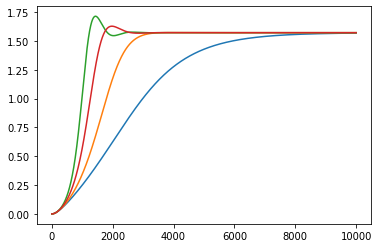

In [5]:
%clear
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import Dense
from sklearn.metrics import mean_squared_error


from Euler_approximation import euler #import euler approximation

[a1,a2,a3,a4]=[20,40,60,80] 
[phi1_a1,phi2_a1]=euler(a1)
[phi1_a2,phi2_a2]=euler(a2)
[phi1_a3,phi2_a3]=euler(a3)
[phi1_a4,phi2_a4]=euler(a4)


plt.plot(phi1_a1)
plt.plot(phi1_a2)
plt.plot(phi1_a4)
plt.plot(phi1_a3)

In [42]:
[a1,a2,a3,a4]=[20,40,60,80] # four sets of magnetic field strength 
 # Get data sequence through Euler approximatiion
[phi1_a1,phi2_a1]=euler(a1)
[phi1_a2,phi2_a2]=euler(a2)
[phi1_a3,phi2_a3]=euler(a3)
[phi1_a4,phi2_a4]=euler(a4)

split_time =8000
T=10000
di=0.001
#Put all angle sequence together
phi1_all=np.concatenate((phi1_a1[:split_time],phi1_a2[:split_time],phi1_a3[:split_time],phi1_a4[:split_time]),axis=0)

 # Calculate the angular velocity
phi2_a1[:split_time]=(phi1_a1[1:split_time+1]-phi1_a1[:split_time])/di
phi2_a2[:split_time]=(phi1_a2[1:split_time+1]-phi1_a2[:split_time])/di
phi2_a3[:split_time]=(phi1_a3[1:split_time+1]-phi1_a3[:split_time])/di
phi2_a4[:split_time]=(phi1_a4[1:split_time+1]-phi1_a4[:split_time])/di
phi2_all=np.concatenate((phi2_a1[:split_time],phi2_a2[:split_time],phi2_a3[:split_time],phi2_a4[:split_time]),axis=0)

 # Calculate the angular acceleration
phi2_diff_all=np.concatenate((phi2_a1[1:split_time+1]-phi2_a1[:split_time],phi2_a2[1:split_time+1]-phi2_a2[:split_time],
                              phi2_a3[1:split_time+1]-phi2_a3[:split_time],phi2_a4[1:split_time+1]-phi2_a4[:split_time]),axis=0)
phi2_diff_all=phi2_diff_all/di

# Get the control input sequence 
input_a1=a1*np.ones(T)
input_a2=a2*np.ones(T)
input_a3=a3*np.ones(T)
input_a4=a4*np.ones(T)
input_all=np.concatenate((input_a1[:split_time],input_a2[:split_time],input_a3[:split_time],input_a4[:split_time]),axis=0)
 
# Stack all data together
series_input=np.stack((input_all,phi1_all,phi2_all,phi2_diff_all),axis=1)
series_input=series_input.reshape(4*split_time,4)

#Shuffle data for avioding overfitting
series_input=tf.random.shuffle(series_input)

x_train=series_input[:,0:3] # Training input dataset
x_train=tf.reshape(x_train, [1,4*split_time,3])
y_train=series_input[:,3] # Training output dataset
y_train=tf.reshape(y_train, [1,4*split_time,1])

In [46]:
y_train



<tf.Tensor: shape=(1, 32000, 1), dtype=float64, numpy=
array([[[ 1.70974346e-08],
        [-3.51205169e+00],
        [-1.59732917e+00],
        ...,
        [-1.10467191e-06],
        [ 4.72030733e-01],
        [-1.64836929e-02]]])>

In [44]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)
# window_size = 64
# batch_size = 256

# train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
# input_set = windowed_dataset(input, window_size, batch_size, shuffle_buffer_size)
# print(train_set)
# print(x_train.shape)

#initializer = tf.keras.initializers.Ones()
# model = tf.keras.models.Sequential([tf.keras.layers.SimpleRNN(60, return_sequences=True, input_shape=[None, 3]),
#                                     tf.keras.layers.SimpleRNN(20, return_sequences=True),
#                                     tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(1))
# ])

model = tf.keras.models.Sequential([
  tf.keras.layers.SimpleRNN(60,input_shape=(None, 3),return_sequences=True),  
  tf.keras.layers.LSTM(30, return_sequences=True),
    tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

# input_layer = tf.keras.layers.Input(shape=(None,1),batch_size=1)

# cell = tf.keras.layers.LSTMCell(
#     3,
#     kernel_initializer='glorot_uniform',
#     recurrent_initializer='glorot_uniform',
#     bias_initializer='zeros',
# )

# lstm = tf.keras.layers.RNN(
#     cell,
#     return_state=True,
#     return_sequences=True,
#     stateful=True
#      )

# lstm_out, hidden_state, cell_state = lstm(input_layer)

# #lstm_out, hidden_state, cell_state = tf.keras.layers.LSTM(3,return_state=True, return_sequences=True)(lstm_out)


# # output1 = tf.keras.layers.Dense(30, activation="elu")(lstm_out)
# # output = tf.keras.layers.Dense(3)(output1)

# output = lstm_out
# model = tf.keras.Model(
#     inputs=input_layer,
#     outputs=output
# )
# model = tf.keras.models.Sequential([
#        tf.keras.layers.LSTM(3, batch_input_shape=(1, 1, 3), return_sequences=True, stateful=True),
# #       tf.keras.layers.SimpleRNN(2, input_shape=(1,1),return_sequences=True,use_bias=False), 
# #       tf.keras.layers.TimeDistributed(Dense(32,activation='linear',use_bias=False)),     
#        tf.keras.layers.TimeDistributed(Dense(1))                   
# ])

# model = tf.keras.models.Sequential([
#        tf.keras.layers.SimpleRNN(2, input_shape=(1,1),return_sequences=True,activation='relu',use_bias=False),  
# #       tf.keras.layers.SimpleRNN(2, input_shape=(1,1),return_sequences=True,use_bias=False), 
# #       tf.keras.layers.TimeDistributed(Dense(32,activation='linear',use_bias=False)),     
#        tf.keras.layers.TimeDistributed(Dense(1,activation='relu',use_bias=False,kernel_initializer=initializer))                        
# ])

# model = tf.keras.models.Sequential([
#   tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
#                       input_shape=[None]),
#     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
#   tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
#   tf.keras.layers.Dense(1),
#   tf.keras.layers.Lambda(lambda x: x * 100.0)
# ])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-5 * 10**(epoch / 20))

checkpoint_cb = tf. keras.callbacks.ModelCheckpoint("my_keras_model.h5")
class CustomCallbacks(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
      if(logs.get('mae')<1):
        print("\n 99% acc reached")
        self.model.stop_training = True

optimizer = tf.keras.optimizers.Adam(lr=1e-5)#, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(x_train, y_train, epochs=500)#,callbacks=[CustomCallbacks()])


Epoch 1/500
1/1 [==============================] - 29s 29s/step - loss: 32.9116 - mae: 33.4116
Epoch 2/500
1/1 [==============================] - 31s 31s/step - loss: 31.8741 - mae: 32.3741
Epoch 3/500
1/1 [==============================] - 34s 34s/step - loss: 30.8366 - mae: 31.3366
Epoch 4/500
1/1 [==============================] - 34s 34s/step - loss: 29.7991 - mae: 30.2991
Epoch 5/500
1/1 [==============================] - 34s 34s/step - loss: 28.7614 - mae: 29.2614
Epoch 6/500
1/1 [==============================] - 34s 34s/step - loss: 27.7237 - mae: 28.2237
Epoch 7/500
1/1 [==============================] - 34s 34s/step - loss: 26.6859 - mae: 27.1859
Epoch 8/500
1/1 [==============================] - 34s 34s/step - loss: 25.6480 - mae: 26.1480
Epoch 9/500
1/1 [==============================] - 34s 34s/step - loss: 24.6100 - mae: 25.1100
Epoch 10/500
1/1 [==============================] - 35s 35s/step - loss: 23.5720 - mae: 24.0719
Epoch 11/500
1/1 [==============================]

1/1 [==============================] - 33s 33s/step - loss: 5.0183 - mae: 5.4985
Epoch 88/500
1/1 [==============================] - 33s 33s/step - loss: 5.0080 - mae: 5.4880
Epoch 89/500
1/1 [==============================] - 33s 33s/step - loss: 4.9978 - mae: 5.4777
Epoch 90/500
1/1 [==============================] - 33s 33s/step - loss: 4.9875 - mae: 5.4674
Epoch 91/500
1/1 [==============================] - 33s 33s/step - loss: 4.9772 - mae: 5.4570
Epoch 92/500
1/1 [==============================] - 33s 33s/step - loss: 4.9668 - mae: 5.4465
Epoch 93/500
1/1 [==============================] - 33s 33s/step - loss: 4.9561 - mae: 5.4357
Epoch 94/500
1/1 [==============================] - 33s 33s/step - loss: 4.9452 - mae: 5.4248
Epoch 95/500
1/1 [==============================] - 33s 33s/step - loss: 4.9342 - mae: 5.4136
Epoch 96/500
1/1 [==============================] - 33s 33s/step - loss: 4.9229 - mae: 5.4023
Epoch 97/500
1/1 [==============================] - 33s 33s/step - loss: 

1/1 [==============================] - 33s 33s/step - loss: 4.1074 - mae: 4.5840
Epoch 174/500
1/1 [==============================] - 33s 33s/step - loss: 4.0973 - mae: 4.5739
Epoch 175/500
1/1 [==============================] - 33s 33s/step - loss: 4.0873 - mae: 4.5638
Epoch 176/500
1/1 [==============================] - 33s 33s/step - loss: 4.0772 - mae: 4.5537
Epoch 177/500
1/1 [==============================] - 33s 33s/step - loss: 4.0672 - mae: 4.5437
Epoch 178/500
1/1 [==============================] - 33s 33s/step - loss: 4.0572 - mae: 4.5336
Epoch 179/500
1/1 [==============================] - 33s 33s/step - loss: 4.0472 - mae: 4.5236
Epoch 180/500
1/1 [==============================] - 33s 33s/step - loss: 4.0373 - mae: 4.5136
Epoch 181/500
1/1 [==============================] - 33s 33s/step - loss: 4.0273 - mae: 4.5036
Epoch 182/500
1/1 [==============================] - 33s 33s/step - loss: 4.0174 - mae: 4.4936
Epoch 183/500
1/1 [==============================] - 33s 33s/ste

1/1 [==============================] - 33s 33s/step - loss: 3.3125 - mae: 3.7842
Epoch 260/500
1/1 [==============================] - 34s 34s/step - loss: 3.3043 - mae: 3.7760
Epoch 261/500
1/1 [==============================] - 33s 33s/step - loss: 3.2961 - mae: 3.7677
Epoch 262/500
1/1 [==============================] - 33s 33s/step - loss: 3.2879 - mae: 3.7595
Epoch 263/500
1/1 [==============================] - 33s 33s/step - loss: 3.2798 - mae: 3.7513
Epoch 264/500
1/1 [==============================] - 33s 33s/step - loss: 3.2716 - mae: 3.7431
Epoch 265/500
1/1 [==============================] - 33s 33s/step - loss: 3.2636 - mae: 3.7350
Epoch 266/500
1/1 [==============================] - 33s 33s/step - loss: 3.2555 - mae: 3.7268
Epoch 267/500
1/1 [==============================] - 33s 33s/step - loss: 3.2474 - mae: 3.7187
Epoch 268/500
1/1 [==============================] - 33s 33s/step - loss: 3.2394 - mae: 3.7107
Epoch 269/500
1/1 [==============================] - 33s 33s/ste

1/1 [==============================] - 33s 33s/step - loss: 2.7105 - mae: 3.1751
Epoch 346/500
1/1 [==============================] - 33s 33s/step - loss: 2.7048 - mae: 3.1693
Epoch 347/500
1/1 [==============================] - 33s 33s/step - loss: 2.6990 - mae: 3.1635
Epoch 348/500
1/1 [==============================] - 33s 33s/step - loss: 2.6934 - mae: 3.1577
Epoch 349/500
1/1 [==============================] - 33s 33s/step - loss: 2.6877 - mae: 3.1520
Epoch 350/500
1/1 [==============================] - 33s 33s/step - loss: 2.6821 - mae: 3.1463
Epoch 351/500
1/1 [==============================] - 33s 33s/step - loss: 2.6764 - mae: 3.1406
Epoch 352/500
1/1 [==============================] - 33s 33s/step - loss: 2.6709 - mae: 3.1350
Epoch 353/500
1/1 [==============================] - 33s 33s/step - loss: 2.6653 - mae: 3.1293
Epoch 354/500
1/1 [==============================] - 33s 33s/step - loss: 2.6598 - mae: 3.1237
Epoch 355/500
1/1 [==============================] - 33s 33s/ste

1/1 [==============================] - 33s 33s/step - loss: 2.2943 - mae: 2.7551
Epoch 432/500
1/1 [==============================] - 34s 34s/step - loss: 2.2902 - mae: 2.7509
Epoch 433/500
1/1 [==============================] - 33s 33s/step - loss: 2.2861 - mae: 2.7468
Epoch 434/500
1/1 [==============================] - 33s 33s/step - loss: 2.2820 - mae: 2.7427
Epoch 435/500
1/1 [==============================] - 33s 33s/step - loss: 2.2779 - mae: 2.7386
Epoch 436/500
1/1 [==============================] - 33s 33s/step - loss: 2.2739 - mae: 2.7345
Epoch 437/500
1/1 [==============================] - 33s 33s/step - loss: 2.2698 - mae: 2.7305
Epoch 438/500
1/1 [==============================] - 33s 33s/step - loss: 2.2658 - mae: 2.7264
Epoch 439/500
1/1 [==============================] - 33s 33s/step - loss: 2.2618 - mae: 2.7223
Epoch 440/500
1/1 [==============================] - 33s 33s/step - loss: 2.2578 - mae: 2.7183
Epoch 441/500
1/1 [==============================] - 33s 33s/ste

In [45]:
model.save('RNN4.h5') 

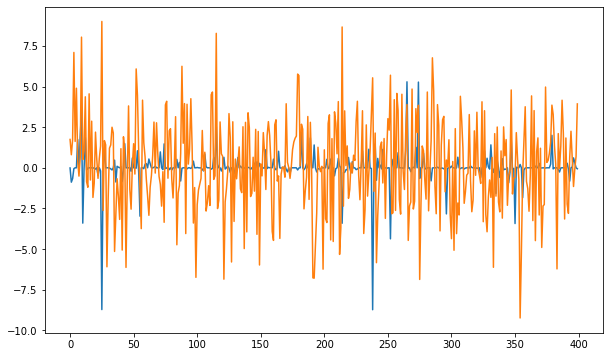

In [48]:
Predict=model.predict(x_train)

# plt.figure(figsize=(10, 6))
# plot_series(range(length), x_difference[:,0])
# plot_series(range(length), np.array(trainPredict[:,0]))

plt.figure(figsize=(10, 6))
plt.plot(y_train[0,100:500,0])
plt.plot(Predict[0,100:500,0])

# plt.figure(figsize=(10, 6))
# plt.plot(y_test[0,:,0])
# plt.plot(Predict[0,:,0])
# plt.figure(figsize=(10, 6))
# plt.plot(y_test[0,:,1])
# plt.plot(Predict[0,:,1])
# plt.figure(figsize=(10, 6))
# plt.plot(y_test[0,:,0])
# plt.plot(Predict[0,:,0])

# plt.figure(figsize=(10, 6))
# plt.plot(y_test[0,:,1])
# plt.plot(Predict[0,:,1])

# plt.figure(figsize=(10, 6))
# plt.plot(y_test[0,:,2])
# plt.plot(Predict[0,:,2])

#rnn_forecast= model_forecast(model, 30, window_size) X-0-80  Y 80-100 sequence to s   s to p  y 81